In [2]:
!pip install --upgrade pip
!pip install praw
!pip install wordcloud
!pip install vaderSentiment
!pip install psycopg2
!python -m spacy download en_core_web_lg
!pip install better-profanity

/opt/conda/bin/python: No module named spacy


In [3]:
import re
import nltk
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import datetime
import seaborn as sns
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
import praw

# Data loading and PreProcessing

In [4]:
def get_db_reddit(table, utc_begin, utc_end):
    """
    Retrieves posts from our AWS PostgreSQL database within a specified UTC time range.

    Parameters:
    table (str): Name of the database table to query.
    utc_begin (int): The beginning of the UTC time range.
    utc_end (int): The end of the UTC time range.

    Returns:
    DataFrame: A pandas DataFrame containing the retrieved posts.

    Raises:
    psycopg2.DatabaseError: If an error occurs in database connection or execution.
    """
    connection_params = {
        "user": 'postgres',
        "password": 'Data2023',
        "host": 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
        "port": 5432,
        "database": "mads"
    }


    try:
        with psycopg2.connect(**connection_params) as db_connection:
            select_query = f"SELECT * FROM {table} WHERE created_utc >= %s AND created_utc <= %s;"

            cursor = db_connection.cursor()
            cursor.execute(select_query, (utc_begin, utc_end))
            rows = cursor.fetchall()
            
            df = pd.DataFrame(rows,)
            if table == 'submissions':
                df.columns= ["id", "subreddit_id", "subreddit", "author", "created_utc", "permalink", "title", "selftext", "num_comments", "score"]
            elif table == 'comments':
                df.columns= ["id", "subreddit_id","submission_id", "subreddit", "author", "created_utc","selftext", "score"]
            else:
                print('Table not found!')
                raise
                                  
            return df
        
    except psycopg2.DatabaseError as e:
        print(f"Database error: {e}")
        raise

In [5]:
def get_reddit_praw_submissions(limit):
    
    client_id = 'aWEYVIaAoJGlCPja3awh0A'
    secret = 'gOR5FfkvsTH3MJ0IHRSImToTwt0PSQ'

    reddit = praw.Reddit(
                        client_id=client_id,
                        client_secret=secret,
                        user_agent="MADS/0.1 by TeamSafari",
                    )
    submissions_data = []

    for submission in reddit.subreddit("wallstreetbets").new(limit=limit):
        # print(dir(submission))
        data = {
            'id': submission.id,
            'subreddit_id': submission.subreddit_id,
            'subreddit': submission.subreddit,
            'author': submission.author,
            'created_utc': submission.created_utc,
            'permalink': submission.permalink,
            'title': submission.title,
            'selftext': submission.selftext,
            'num_comments': submission.num_comments,
            'score': submission.score,
            'flair': submission.link_flair_text,
            'removal_reason':submission.removal_reason,
            

            # Add more fields as needed
        }
        submissions_data.append(data)

    df = pd.DataFrame(submissions_data)
    return df

## Choose data source

In [6]:
utc_begin = int(datetime.datetime(2021, 2, 20, 23, 59, 59).replace(tzinfo=datetime.timezone.utc).timestamp())
utc_end = int(datetime.datetime(2021,2, 21, 23, 59, 59).replace(tzinfo=datetime.timezone.utc).timestamp())

In [7]:
# date_time = datetime.datetime.utcfromtimestamp(1651363199).date()
# print(date_time)

In [8]:
%time # df = get_db_reddit(table='submissions',utc_begin=utc_begin, utc_end=utc_end)
df = get_reddit_praw_submissions(limit=1000)
df

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,flair,removal_reason
0,18f77hp,t5_2th52,wallstreetbets,Zorg_Employee,1.702226e+09,/r/wallstreetbets/comments/18f77hp/am_i_fucked...,Am I fucked? I have some worthless options tha...,I'm using Robinhood and can't sell them since ...,36,3,Discussion,None
1,18f6ebm,t5_2th52,wallstreetbets,tringitdad,1.702223e+09,/r/wallstreetbets/comments/18f6ebm/am_i_doing_...,Am I doing this right? Do I get a sticker or a...,Enjoy the loss porn.,18,22,Loss,None
2,18f6als,t5_2th52,wallstreetbets,jaypowwow,1.702223e+09,/r/wallstreetbets/comments/18f6als/accurate/,Accurate,,5,69,Meme,None
3,18f5r58,t5_2th52,wallstreetbets,Master_Jee,1.702221e+09,/r/wallstreetbets/comments/18f5r58/puts_on_mor...,Puts on Morgan. Tf happened to the JP 🧐,"Bank Street, Canary Wharf, London, 10/12/23",33,79,Meme,None
4,18f3kl7,t5_2th52,wallstreetbets,Code_Extension,1.702215e+09,/r/wallstreetbets/comments/18f3kl7/what_could_...,What could possibly go wrong?,With overnight trading hours you can trade tho...,6,0,Discussion,None
...,...,...,...,...,...,...,...,...,...,...,...,...
892,180twqg,t5_2th52,wallstreetbets,realstocknear,1.700607e+09,/r/wallstreetbets/comments/180twqg/the_openai_...,The OpenAI situation summarized by Silicon Valley,,72,2089,Meme,None
893,180tudd,t5_2th52,wallstreetbets,naynancy,1.700607e+09,/r/wallstreetbets/comments/180tudd/brands_cate...,Brands Catering to Upper Middle Class Are Stru...,,710,1774,Chart,None
894,180tor0,t5_2th52,wallstreetbets,eichenes,1.700606e+09,/r/wallstreetbets/comments/180tor0/amazon_amzn...,Amazon (AMZN) founder Jeff Bezos is expected t...,,47,166,News,None
895,180tg8a,t5_2th52,wallstreetbets,RaleighBahn,1.700606e+09,/r/wallstreetbets/comments/180tg8a/every_time_...,"Every time the closing bell rings, a regard ge...",,6,51,Meme,None


## Text pre-processing

In [11]:
def preprocess_df(df):
#     def preprocess_text(text):
        
#         # Remove specific unwanted characters
#         text = re.sub(r'[^A-Za-z0-9\s,.!?;:()\'\"-]', '', text)
        
#         # Strip whitespace
#         text = text.strip()
        
#         return text
        # Load the list of profane words
    with open(r'/root/Git_Repo/SIADS_Capstone_Group17/Data/LDNOOBW.txt', 'r') as file:
        profanity_list = [line.strip() for line in file]

    def preprocess_text(text):
        # Remove specific unwanted characters
        text = re.sub(r'[^A-Za-z0-9\s,.!?;:()\'\"-]', '', text)

        # Replace profane words
        pattern = re.compile(r'\b(' + '|'.join(map(re.escape, profanity_list)) + r')\b', re.IGNORECASE)
        # text = pattern.sub("*censored*", text)
        text = pattern.sub("****", text)
        # Strip whitespace
        text = text.strip()

        return text
    
    
    try:
        df['title'] = df['title'].fillna('')
        df['title'] = df['title'].apply(preprocess_text)

        # Create a new column with shifted values
        df['title_prior'] = df['title'].shift(1)
        # Drop rows where the value in 'ColumnToCheck' is the same as in 'ShiftedColumn'
        df = df[df['title'] != df['title_prior']]
        # drop the 'ShiftedColumn'
        df = df.drop('title_prior', axis=1)
        
    except:
        print(f'No title found, skipping')
    
    
    # handle blank 
    df['selftext'] = df['selftext'].fillna('') 
    
    # preprocess selftext
    df['selftext'] = df['selftext'].apply(preprocess_text)
    
    # localize the UTC time stamp
    df['created_EST_date'] = pd.to_datetime(df['created_utc'], unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.date
    
    
    return df
    

In [12]:
df = preprocess_df(df)
df

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,flair,removal_reason,created_EST_date
0,18f77hp,t5_2th52,wallstreetbets,Zorg_Employee,1.702226e+09,/r/wallstreetbets/comments/18f77hp/am_i_fucked...,Am I fucked? I have some worthless options tha...,I'm using Robinhood and can't sell them since ...,36,3,Discussion,None,2023-12-10
1,18f6ebm,t5_2th52,wallstreetbets,tringitdad,1.702223e+09,/r/wallstreetbets/comments/18f6ebm/am_i_doing_...,Am I doing this right? Do I get a sticker or a...,Enjoy the loss ****.,18,22,Loss,None,2023-12-10
2,18f6als,t5_2th52,wallstreetbets,jaypowwow,1.702223e+09,/r/wallstreetbets/comments/18f6als/accurate/,Accurate,,5,69,Meme,None,2023-12-10
3,18f5r58,t5_2th52,wallstreetbets,Master_Jee,1.702221e+09,/r/wallstreetbets/comments/18f5r58/puts_on_mor...,Puts on Morgan. Tf happened to the JP,"Bank Street, Canary Wharf, London, 101223",33,79,Meme,None,2023-12-10
4,18f3kl7,t5_2th52,wallstreetbets,Code_Extension,1.702215e+09,/r/wallstreetbets/comments/18f3kl7/what_could_...,What could possibly go wrong?,With overnight trading hours you can trade tho...,6,0,Discussion,None,2023-12-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,180twqg,t5_2th52,wallstreetbets,realstocknear,1.700607e+09,/r/wallstreetbets/comments/180twqg/the_openai_...,The OpenAI situation summarized by Silicon Valley,,72,2089,Meme,None,2023-11-21
893,180tudd,t5_2th52,wallstreetbets,naynancy,1.700607e+09,/r/wallstreetbets/comments/180tudd/brands_cate...,Brands Catering to Upper Middle Class Are Stru...,,710,1774,Chart,None,2023-11-21
894,180tor0,t5_2th52,wallstreetbets,eichenes,1.700606e+09,/r/wallstreetbets/comments/180tor0/amazon_amzn...,Amazon (AMZN) founder Jeff Bezos is expected t...,,47,166,News,None,2023-11-21
895,180tg8a,t5_2th52,wallstreetbets,RaleighBahn,1.700606e+09,/r/wallstreetbets/comments/180tg8a/every_time_...,"Every time the closing bell rings, a regard ge...",,6,51,Meme,None,2023-11-21


# Ticker Extraction

In [15]:
def find_tickers(df):
 
    # Load tickers from a CSV file
    stocks = pd.read_csv(r'/root/Git_Repo/SIADS_Capstone_Group17/Data/nasdaq_screener.csv')

    # Directly convert the 'Symbol' column to a set
    tickers_set = set(stocks['Symbol'])

    # Use set union to add additional tickers
    additional_tickers = {'BBBY'}
    tickers_set = tickers_set.union(additional_tickers)
    
    # Adjust the pattern to optionally include a leading '$'
    # pattern = r'\b\$?(?:' + '|'.join(tickers_as_strings) + r')\b'
    # pattern = r'\b\$?(?:\(?)(?:' + '|'.join(tickers_as_strings) + r')(?:\)?)\b'
    pattern = r'\b[A-Z]{2,5}\b'
    compiled_pattern = re.compile(pattern)
    
    
    
    blacklist = {
#                 {'I', 'ELON', 'WSB', 'THE', 'A', 'ROPE', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR',
#              'DEC', 'BE',
                'IMO',# 'ALL', 'RH', 'EV', 'TOS', 'CFO', 'CTO',
                'DD',
                #'BTFD', 'WSB', 'OK', 'PDT', 'RH', 'KYS', 'FD',
#              'TYS', 
                'US',
                'USA',
                # 'IT', 'ATH', 'RIP', 'BMW', 'GDP', 'OTM', 'ATM', 'ITM', 
                'IMO', 'LOL', 'AM', 'BE', 'PR', 'PRAY',
#              'PT', 'FBI', 'SEC', 'GOD', 'NOT', 'POS', 'FOMO', 'TL;DR',
                'EDIT', 'STILL', 'WTF', 'RAW', 'PM', 'LMAO', 'LMFAO',
#              'ROFL', 'EZ', 'RED', 'BEZOS', 'TICK', 'IS', 'PM', 'LPT', 'GOAT', 'FL', 'CA', 'IL', 'MACD', 'HQ', 'OP', 'PS', 'AH',
#              'TL', 'JAN', 'FEB', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'FDA', 'IV', 'ER', 'IPO', 'MILF', 'BUT', 'SSN', 'FIFA',
#              'USD', 'CPU', 'AT', 'GG', 'Mar', 
            
#                # Jake added
                'RUN', # common
                'SAY', # common
                'EOD', # end of day
                'BIG', # common
                'LOW', # low / high
                'RSI', #relative strenght
                'DT', #double top
                'HUGE',
                'U', # you
                'AI', # Artificial Intelligence
                'DC', # washington DC
                'J', # as in J Powell
                'ES', # E-mini SP future
                'F', # f*ck
                'GO',
                'UK', # United Kingdom
                'EU', # european union
                'RH', # Robinhood, not Restoration Hardware
                'E', # E*trade brokerage
                'L', # L for loss, P&L etc
                'R', # common 
                'K', # OK
                'B', # common in BBBY odd spacing (spam?)
                'TD', # TD Ameritrade brokerage
                'RYAN', # Ryan Cohen, CEO of GME
                'NYC', # New York City
                'REG', # reg SHO 
                'SHO', # reg SHO 
                'NEXT', # common
                'FREE', # spam
                'DM', # direct message
                'TV', # television
                'ENS', # ethereum name service, spam
                'IRS', # internal revenue service
                'PR', # public relations
                'IQ', # intelligence quotient
                'VS', # versus
                'PT', # price target
                'IBKR', # interactive brokers
                'GOOD', # common
                'OPEN', # market open
                'FCF', # free cash flow
        
                 
                }
    
    combined_blacklist = set(blacklist) | set(word.upper() for word in stopwords.words('english'))
       
    
    def find_tickers(text, compiled_pattern, tickers_set, blacklist_set):
        # Find all matches
        potential_tickers = compiled_pattern.findall(text)
        # Filter matches against the tickers list and ensure they are not in the blacklist
        return list(set([ticker for ticker in potential_tickers if ticker in tickers_set and ticker not in combined_blacklist]))

    try:
        df['title_tickers'] = df['title'].apply(lambda x: find_tickers(x, compiled_pattern, tickers_set, combined_blacklist))
    except KeyError:
        print('title not found, working with comments?')
        
    
    df['selftext_tickers'] = df['selftext'].apply(lambda x: find_tickers(x, compiled_pattern, tickers_set, combined_blacklist))
    
    df['tickers'] = [list(set(x + y)) for x, y in zip(df['title_tickers'], df['selftext_tickers'])]
    
    return df

In [16]:
df_tickers = find_tickers(df)
df_tickers.head(20)

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,flair,removal_reason,created_EST_date,title_tickers,selftext_tickers,tickers
0,18f77hp,t5_2th52,wallstreetbets,Zorg_Employee,1.702226e+09,/r/wallstreetbets/comments/18f77hp/am_i_fucked...,Am I fucked? I have some worthless options tha...,I'm using Robinhood and can't sell them since ...,36,3,Discussion,None,2023-12-10,[],[],[]
1,18f6ebm,t5_2th52,wallstreetbets,tringitdad,1.702223e+09,/r/wallstreetbets/comments/18f6ebm/am_i_doing_...,Am I doing this right? Do I get a sticker or a...,Enjoy the loss ****.,18,22,Loss,None,2023-12-10,[],[],[]
2,18f6als,t5_2th52,wallstreetbets,jaypowwow,1.702223e+09,/r/wallstreetbets/comments/18f6als/accurate/,Accurate,,5,69,Meme,None,2023-12-10,[],[],[]
3,18f5r58,t5_2th52,wallstreetbets,Master_Jee,1.702221e+09,/r/wallstreetbets/comments/18f5r58/puts_on_mor...,Puts on Morgan. Tf happened to the JP,"Bank Street, Canary Wharf, London, 101223",33,79,Meme,None,2023-12-10,[],[],[]
4,18f3kl7,t5_2th52,wallstreetbets,Code_Extension,1.702215e+09,/r/wallstreetbets/comments/18f3kl7/what_could_...,What could possibly go wrong?,With overnight trading hours you can trade tho...,6,0,Discussion,None,2023-12-10,[],[ET],[ET]
5,18eyh68,t5_2th52,wallstreetbets,Alternative-Ear-2548,1.702194e+09,/r/wallstreetbets/comments/18eyh68/what_would_...,What would happen if everyone quit their jobs ...,Would jpow be forced to cut interest rates the...,83,0,Discussion,None,2023-12-10,[],[],[]
6,18exlbf,t5_2th52,wallstreetbets,BakaGaijiin,1.702191e+09,/r/wallstreetbets/comments/18exlbf/treasury_se...,Treasury Securities Purchased by the Federal R...,,8,41,News,None,2023-12-10,[],[],[]
7,18exhpj,t5_2th52,wallstreetbets,reddit_insta_fb,1.702190e+09,/r/wallstreetbets/comments/18exhpj/when_are_th...,When are the benefits of AI coming to life to ...,With the pace with which AI is accelerating an...,63,2,Discussion,None,2023-12-10,[],[SP],[SP]
8,18ew3ba,t5_2th52,wallstreetbets,Minority_Carrier,1.702185e+09,/r/wallstreetbets/comments/18ew3ba/nice_gains_...,Nice gains big loss overall,Guess when I found about option trading?,21,40,Loss,None,2023-12-10,[],[],[]
9,18evp8z,t5_2th52,wallstreetbets,Worried_Quarter469,1.702183e+09,/r/wallstreetbets/comments/18evp8z/time_to_up_...,Time to up your trading game,,65,266,Meme,None,2023-12-09,[],[],[]


In [17]:
df_tickers_exist = df_tickers[df_tickers['tickers'].apply(lambda x: x!= []) ]
df_tickers_exist

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,flair,removal_reason,created_EST_date,title_tickers,selftext_tickers,tickers
4,18f3kl7,t5_2th52,wallstreetbets,Code_Extension,1.702215e+09,/r/wallstreetbets/comments/18f3kl7/what_could_...,What could possibly go wrong?,With overnight trading hours you can trade tho...,6,0,Discussion,None,2023-12-10,[],[ET],[ET]
7,18exhpj,t5_2th52,wallstreetbets,reddit_insta_fb,1.702190e+09,/r/wallstreetbets/comments/18exhpj/when_are_th...,When are the benefits of AI coming to life to ...,With the pace with which AI is accelerating an...,63,2,Discussion,None,2023-12-10,[],[SP],[SP]
13,18etail,t5_2th52,wallstreetbets,notbutterface,1.702175e+09,/r/wallstreetbets/comments/18etail/penn_am_i_m...,PENN - Am I missing something?,"In my eyes its incredibly undervalued, but I d...",20,12,DD,None,2023-12-09,[PENN],"[MGM, NC, DKNG, PENN]","[MGM, NC, DKNG, PENN]"
15,18eraxq,t5_2th52,wallstreetbets,badtradesguynumber2,1.702168e+09,/r/wallstreetbets/comments/18eraxq/anyone_eyei...,anyone eyeing Oil and tickers inverse to rate ...,I picked up some xlth a while back and am up 9...,50,21,Discussion,None,2023-12-09,[],[XOM],[XOM]
18,18epnv1,t5_2th52,wallstreetbets,JafarFromAfar2,1.702163e+09,/r/wallstreetbets/comments/18epnv1/arm_capital...,ARM - Capitalize off the Rug Pull,"As with most IPOs, ARM is overvalued as ****. ...",45,57,DD,None,2023-12-09,[ARM],"[ARM, PB]","[ARM, PB]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,180zmr2,t5_2th52,wallstreetbets,TerranOPZ,1.700623e+09,/r/wallstreetbets/comments/180zmr2/nvda_didnt_...,NVDA Didn't Crush Earnings,I'm seeing a lot of butthurt people pumping th...,252,222,Discussion,None,2023-11-21,[NVDA],[AMD],"[AMD, NVDA]"
885,180yzm7,t5_2th52,wallstreetbets,Reddithatesamerika,1.700622e+09,/r/wallstreetbets/comments/180yzm7/1700_gain_o...,1700 gain on my option and Im still losing mon...,Im a degenerate regard. Started losing in 2021...,29,31,Meme,None,2023-11-21,[],"[DWAC, GOOGL]","[DWAC, GOOGL]"
889,180w7n2,t5_2th52,wallstreetbets,Strongest-There-Is,1.700613e+09,/r/wallstreetbets/comments/180w7n2/soooo_calls...,"Soooo, calls on Coinbase?","Im really, really, really hoping that COIN eme...",57,63,Discussion,None,2023-11-21,[],[COIN],[COIN]
891,180uano,t5_2th52,wallstreetbets,anonymous_pk,1.700608e+09,/r/wallstreetbets/comments/180uano/hood_is_cri...,HOOD is criminally undervalued,x200B;\n\nRobinhood is probably the most under...,126,0,Discussion,None,2023-11-21,[HOOD],"[UI, REAL]","[UI, HOOD, REAL]"


In [18]:
all_tickers = [ticker for sublist in df_tickers_exist['tickers'] for ticker in sublist]

# Count occurrences
ticker_counts = Counter(all_tickers)

# print(ticker_counts)

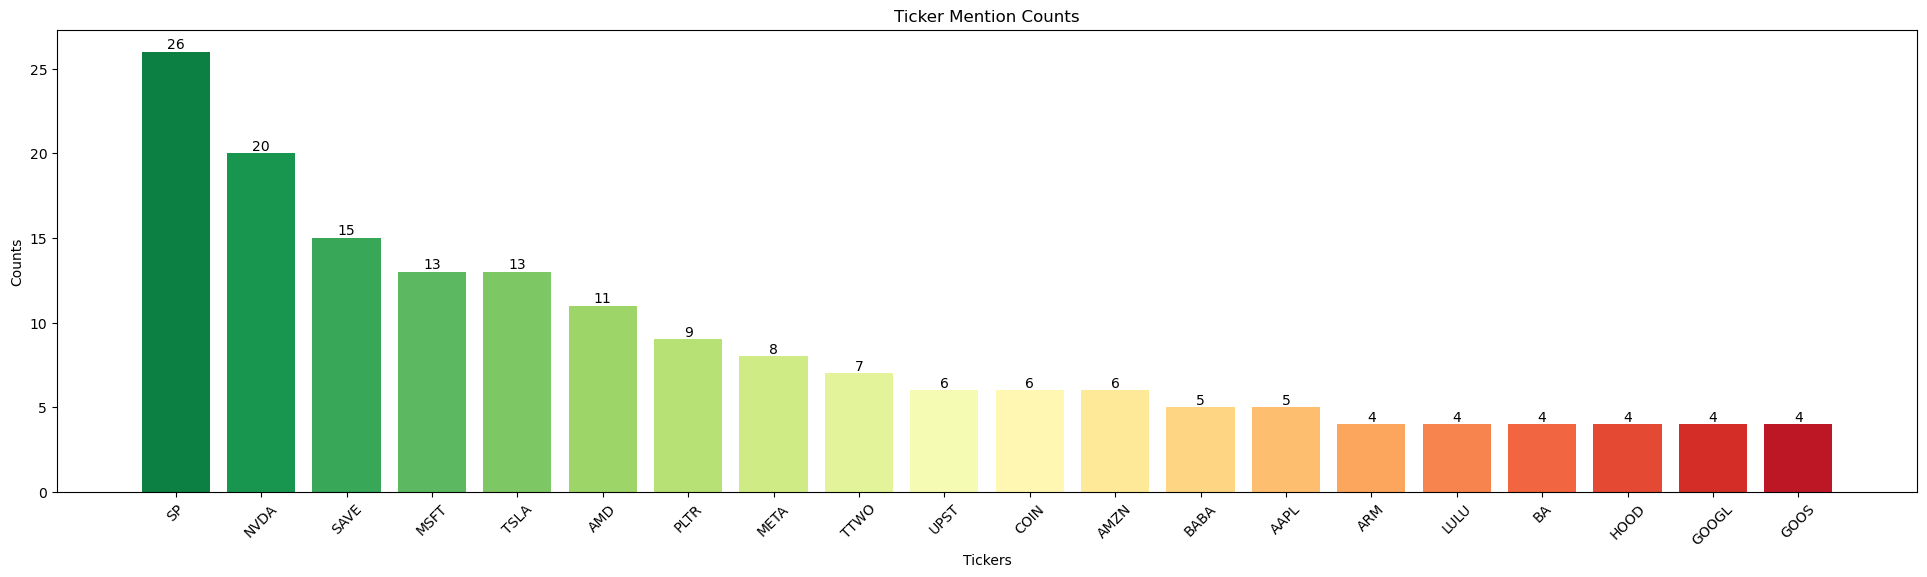

In [19]:
# Optional: Select top N tickers for a cleaner plot
top_n = 20
top_tickers = dict(ticker_counts.most_common(top_n))
palette = sns.color_palette("RdYlGn_r", top_n)
# Creating the bar plot
plt.figure(figsize=(24, 6))
bars = plt.bar(top_tickers.keys(), top_tickers.values(), color=palette)

plt.xlabel('Tickers')
plt.ylabel('Counts')
plt.title('Ticker Mention Counts')
plt.xticks(rotation=45)  # Rotate labels for better readability

# Adding the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Uncomment the next line if you want to use a logarithmic scale
# plt.gca().set_yscale('log')

plt.show()

In [23]:
import plotly.express as px
import plotly.graph_objects as go

# Assuming 'top_tickers' is a dictionary with tickers and their counts
# and 'palette' is a list of colors

# Convert the dictionary to a list of dictionaries for Plotly
data = [{'Ticker': ticker, 'Count': count} for ticker, count in top_tickers.items()]

# Create the bar plot
fig = px.bar(data, x='Ticker', y='Count', 
             color='Count', 
             color_continuous_scale='RdYlGn')

# Update layout for custom axis titles and overall title
fig.update_layout(
    title='Ticker Mention Counts',
    title_x=0.5,
    xaxis_title='Stock Symbols',
    yaxis_title='Count of Mentions',
    xaxis_tickangle=-45,  # Rotate labels for better readability
    coloraxis_colorbar=dict(
        title='Count'  # Colorbar title
    ),
    height=600,
    width=800,
    
)

# Adding the count above each bar
for i, d in enumerate(data):
    fig.add_annotation(
        x=d['Ticker'],
        
        y=d['Count'], 
        text=str(d['Count']), 
        showarrow=False, 
        yshift=10  # Adjust vertical position of the text
    )

# Uncomment the next line if you want to use a logarithmic scale
# fig.update_layout(yaxis_type='log')

fig.show()

In [21]:
df_tickers_exist[df_tickers_exist['tickers'].apply(lambda x: 'HGV' in x)]

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,flair,removal_reason,created_EST_date,title_tickers,selftext_tickers,tickers


In [22]:
unique_title_count = df_tickers_exist['title'].value_counts()

titles_more_than_two = unique_title_count[unique_title_count > 2]

print("Titles with more than 2 instances:")
print(titles_more_than_two)

Titles with more than 2 instances:
Series([], Name: title, dtype: int64)


# Vader Sentiment

In [218]:
def add_vader_sentiment(df):
    
    vader = SentimentIntensityAnalyzer()

    added_words = {
            'citron': -4.0,  
            'hidenburg': -4.0,        
            'moon': 4.0,
            'highs': 2.0,
            'mooning': 4.0,
            'long': 2.0,
            'short': -2.0,
            'call': 4.0,
            'calls': 4.0,    
            'put': -4.0,
            'puts': -4.0,    
            'break': 2.0,
            'tendie': 2.0,
            'tendies': 2.0,
            'town': 2.0,     
            'overvalued': -3.0,
            'undervalued': 3.0,
            'buy': 4.0,
            'sell': -4.0,
            'gone': -1.0,
            'gtfo': -1.7,
            'paper': -1.7,
            'bullish': 3.7,
            'bearish': -3.7,
            'bagholder': -1.7,
            'stonk': 1.9,
            'green': 1.9,
            'money': 1.2,
            'print': 2.2,
            'rocket': 2.2,
            'bull': 2.9,
            'bear': -2.9,
            'pumping': -1.0,
            'sus': -3.0,
            'offering': -2.3,
            'rip': -4.0,
            'downgrade': -3.0,
            'upgrade': 3.0,     
            'maintain': 1.0,          
            'pump': 1.9,
            'hot': 1.5,
            'drop': -2.5,
            'rebound': 1.5,  
            'crack': 2.5,
            '🚀': 3, # Jake ADDED THESE
            '🌕': 3, # Jake ADDED THESE
            'YOLO': 4, # Jake ADDED THESE
            'ripping': 3,# Jake ADDED THESE
            'regarded': 0, # Jake ADDED THESE
            'squeeze':3, # Jake ADDED THESE
            }
    
    vader.lexicon.update(added_words)

    def safe_sentiment(text):
        try:
            # Ensure the input is a non-empty string
            if not isinstance(text, str) or not text.strip():
                return 0

            # Analyze the sentiment
            sentiment_dict = vader.polarity_scores(text)
            return sentiment_dict.get('compound', 0)
        except Exception as e:
            print(f"Error processing text: '{text}' (type: {type(text)}). Error: {e}")
            return 0

    # Apply the function
    try:
        df['title_sentiment'] = df['title'].apply(safe_sentiment)
    except:
        print('Titles not found, is this a comments file?')
        df['title_sentiment'] = 0
        
    df['selftext_sentiment'] = df['selftext'].apply(safe_sentiment)
    
    
    def non_zero_average(row):
        sentiments = [row['title_sentiment'], row['selftext_sentiment']]
        non_zero_sentiments = [s for s in sentiments if s != 0]

        if not non_zero_sentiments:
            return 0  # Return 0 if both sentiments are zero

        return sum(non_zero_sentiments) / len(non_zero_sentiments)

    # Apply the function to calculate overall sentiment
    df['overall_sentiment'] = df.apply(non_zero_average, axis=1)
    
    df['score_weighted_sentiment'] = df['overall_sentiment'] * df['score']

    return df

In [219]:
submission_sentiment = add_vader_sentiment(df_tickers_exist)
submission_sentiment

/tmp/ipykernel_194/3956647881.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_194/3956647881.py:80: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_194/3956647881.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_194/

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,flair,removal_reason,created_EST_date,title_tickers,selftext_tickers,tickers,title_sentiment,selftext_sentiment,overall_sentiment,score_weighted_sentiment
1,18eilgq,t5_2th52,wallstreetbets,grip_n_Ripper,1.702143e+09,/r/wallstreetbets/comments/18eilgq/upst_are_we...,UPST - are we looking at the making of a short...,"It's had a bit of a run lately, and the short ...",5,0,Discussion,None,2023-12-09,[UPST],[],[UPST],0.2500,0.4588,0.35440,0.0000
2,18eig6u,t5_2th52,wallstreetbets,FutureOwn5191,1.702143e+09,/r/wallstreetbets/comments/18eig6u/yolo_and_di...,YOLO and Diamond Hands: Why BYND is a Weakend ...,"Hey fellow degenerates, ...",2,3,Discussion,None,2023-12-09,[BYND],[BYND],[BYND],0.6408,0.9908,0.81580,2.4474
3,18eiaj5,t5_2th52,wallstreetbets,go_far_go_together,1.702142e+09,/r/wallstreetbets/comments/18eiaj5/arm_put_the...,ARM put thesis,I don't ever post here. Don't listen to anyth...,9,14,Discussion,None,2023-12-09,[ARM],[ARM],[ARM],-0.7184,-0.8125,-0.76545,-10.7163
4,18ei2y2,t5_2th52,wallstreetbets,ChewThirty,1.702142e+09,/r/wallstreetbets/comments/18ei2y2/augmedix_me...,Augmedix - Medical AI,With Augmedix and Google Cloud entering a part...,2,1,Discussion,None,2023-12-09,[],[HCA],[HCA],0.0000,0.9912,0.99120,0.9912
14,18ecxrr,t5_2th52,wallstreetbets,Time-Caterpillar-689,1.702126e+09,/r/wallstreetbets/comments/18ecxrr/apples_head...,Apple's head of iphone and Apple watch design ...,Puts or calls for monday?,213,973,News,None,2023-12-09,[AAPL],[],[AAPL],0.0000,0.0000,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,180otmh,t5_2th52,wallstreetbets,chuggerbot,1.700594e+09,/r/wallstreetbets/comments/180otmh/thoughts_on...,Thoughts on SEEL,Disclaimer: Ive got a pretty substantial posit...,11,5,Discussion,None,2023-11-21,[SEEL],"[SEEL, CYBN]","[SEEL, CYBN]",0.0000,0.9873,0.98730,4.9365
882,180o97d,t5_2th52,wallstreetbets,Tendie_Tube,1.700593e+09,/r/wallstreetbets/comments/180o97d/binance_ceo...,Binance CEO Changpeng Zhao to plead guilty to ...,So basically crypto is fed and it is being slo...,25,36,News,None,2023-11-21,[],[COIN],[COIN],-0.5994,-0.6597,-0.62955,-22.6638
888,180m37t,t5_2th52,wallstreetbets,Tendie_Tube,1.700587e+09,/r/wallstreetbets/comments/180m37t/why_longdur...,"Why long-duration, low-coupon treasury bonds a...","As we know, the prices of existing bonds go up...",70,92,DD,None,2023-11-21,[],[CME],[CME],0.2023,0.9845,0.59340,54.5928
892,180l96m,t5_2th52,wallstreetbets,StretchyJeff,1.700585e+09,/r/wallstreetbets/comments/180l96m/get_in_on_r...,Get in on RBT making garbage smart,x200B;\n\nhttps:preview.redd.itv30g304vbq1c1.p...,3,7,YOLO,None,2023-11-21,[RBT],[],[RBT],0.4019,0.0000,0.40190,2.8133


In [220]:
exploded_df = submission_sentiment.explode('tickers')

# Group by 'tickers'
cumulative_sentiment = exploded_df.groupby('tickers')['overall_sentiment'].sum().reset_index()

# Rename columns for clarity
cumulative_sentiment.columns = ['Ticker', 'Cumulative Overall Sentiment']
cumulative_sentiment_sorted = cumulative_sentiment.sort_values(by='Cumulative Overall Sentiment', ascending=False)

display(cumulative_sentiment_sorted)

,Ticker,Cumulative Overall Sentiment
124,NVDA,8.28820
159,SAVE,8.13585
109,META,4.61410
10,AMD,4.60140
115,MSFT,4.33640
...,...,...
170,SUPV,-0.95110
21,BBVA,-0.95110
175,TGS,-0.95110
197,YPF,-0.95110


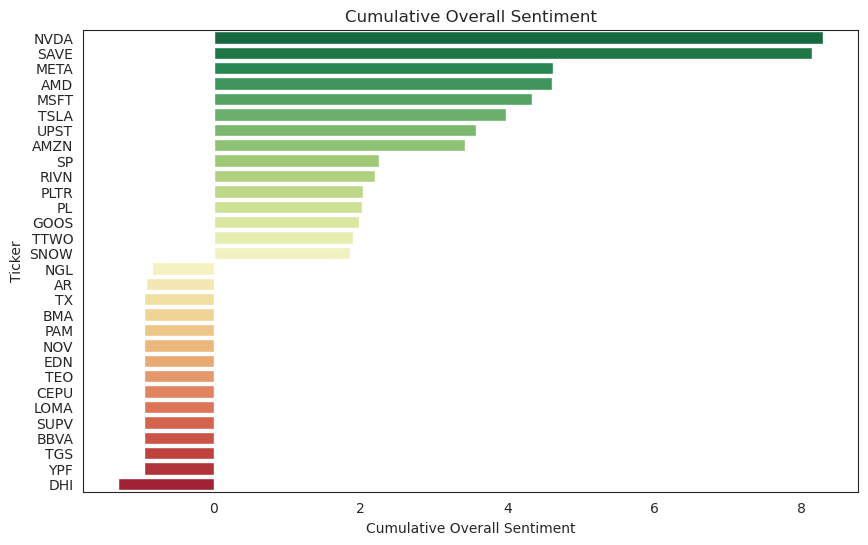

In [221]:
top_bottom = pd.concat([cumulative_sentiment_sorted.head(15), cumulative_sentiment_sorted.tail(15)])

sns.set_style("white")
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cumulative Overall Sentiment', y='Ticker', data=top_bottom, palette='RdYlGn_r')

plt.title('Cumulative Overall Sentiment')
plt.xlabel('Cumulative Overall Sentiment')
plt.ylabel('Ticker')
# plt.grid(True)
plt.show()

In [222]:
import plotly.express as px

top_bottom_sorted = top_bottom.sort_values(by='Cumulative Overall Sentiment', ascending=True)

# Create the bar plot
fig = px.bar(top_bottom_sorted, x='Cumulative Overall Sentiment', y='Ticker', 
             orientation='h',  # Horizontal bar plot
             color='Cumulative Overall Sentiment', 
             color_continuous_scale='RdYlGn')

# Update layout for custom axis titles and overall title
fig.update_layout(
    title='Cumulative Overall Sentiment by Symbol',
    title_x=0.5,
    xaxis_title='Cumulative Overall Sentiment',
    yaxis_title='Ticker Symbol',
    coloraxis_colorbar=dict(
        title='Sentiment'  # Colorbar title
    ),
    height=600,
    width=1200,
)

fig.show()

In [223]:
exploded_df = submission_sentiment.explode('tickers')

# Group by 'tickers' and sum the 'score_weighted_sentiment'
cumulative_weighted_sentiment = exploded_df.groupby('tickers')['score_weighted_sentiment'].sum().reset_index()

# Rename columns for clarity
cumulative_weighted_sentiment.columns = ['Ticker', 'Cumulative Weighted Sentiment']
cumulative_weighted_sentiment_sorted = cumulative_weighted_sentiment.sort_values(by='Cumulative Weighted Sentiment', ascending=False)
cumulative_weighted_sentiment_sorted['Date'] = submission_sentiment['created_EST_date']
cumulative_weighted_sentiment_sorted['Date'].fillna(submission_sentiment['created_EST_date'].unique()[0],inplace=True)
display(cumulative_weighted_sentiment_sorted)

,Ticker,Cumulative Weighted Sentiment,Date
109,META,6855.54015,2023-12-09
124,NVDA,4173.44520,2023-12-09
74,GM,3704.07250,2023-12-09
37,CLSK,3596.47430,2023-12-09
75,GME,2728.42560,2023-12-08
...,...,...,...
77,GOOGL,-178.40955,2023-12-09
10,AMD,-234.06670,2023-12-09
20,BABA,-544.12120,2023-12-08
165,SP,-607.63115,2023-12-06


In [224]:
day_sentiment = cumulative_sentiment_sorted.merge(cumulative_weighted_sentiment_sorted, on='Ticker')
day_sentiment

,Ticker,Cumulative Overall Sentiment,Cumulative Weighted Sentiment,Date
0,NVDA,8.28820,4173.44520,2023-12-09
1,SAVE,8.13585,309.13905,2023-12-06
2,META,4.61410,6855.54015,2023-12-09
3,AMD,4.60140,-234.06670,2023-12-09
4,MSFT,4.33640,789.17750,2023-12-09
...,...,...,...,...
193,SUPV,-0.95110,-7.60880,2023-12-09
194,BBVA,-0.95110,-7.60880,2023-12-09
195,TGS,-0.95110,-7.60880,2023-12-06
196,YPF,-0.95110,-7.60880,2023-12-06


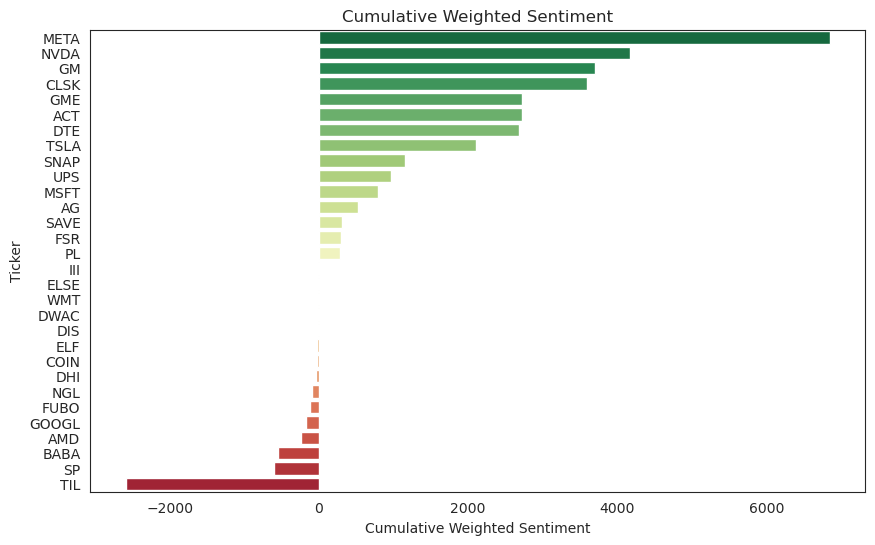

In [225]:
top_bottom = pd.concat([cumulative_weighted_sentiment_sorted.head(15), cumulative_weighted_sentiment_sorted.tail(15)])

sns.set_style("white")
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cumulative Weighted Sentiment', y='Ticker', data=top_bottom, palette='RdYlGn_r')

plt.title('Cumulative Weighted Sentiment')
plt.xlabel('Cumulative Weighted Sentiment')
plt.ylabel('Ticker')
# plt.grid(True)
plt.show()

In [226]:
import plotly.express as px

top_bottom_sorted = top_bottom.sort_values(by='Cumulative Weighted Sentiment', ascending=True)

# Create the bar plot
fig = px.bar(top_bottom_sorted, x='Cumulative Weighted Sentiment', y='Ticker', 
             orientation='h',  # Horizontal bar plot
             color='Cumulative Weighted Sentiment', 
             color_continuous_scale='magma')

# Update layout for custom axis titles and overall title
fig.update_layout(
    title='Cumulative Weighted Sentiment by Symbol',
    title_x=0.5,
    xaxis_title='Cumulative Weighted Sentiment',
    yaxis_title='Ticker Symbol',
    coloraxis_colorbar=dict(
        title='Sentiment'  # Colorbar title
    ),
    height=600,
    width=1200,
)

fig.show()

# N- Grams

In [227]:
import pandas as pd
from nltk.util import ngrams

# Function to add bi-grams and tri-grams to a DataFrame
def add_ngrams_to_df(df, text_column):
    def generate_ngrams(text, n):
        words = text.upper().split()
        return [' '.join(gram) for gram in ngrams(words, n)]

    if text_column in df.columns:
        df['bigrams'] = df[text_column].apply(lambda x: generate_ngrams(x, 2))
        df['trigrams'] = df[text_column].apply(lambda x: generate_ngrams(x, 3))
    else:
        print(f"Column '{text_column}' not found in DataFrame.")
    return df

df_with_ngrams = add_ngrams_to_df(submission_sentiment, 'title')
df_with_ngrams

/tmp/ipykernel_194/152069911.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_194/152069911.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,...,created_EST_date,title_tickers,selftext_tickers,tickers,title_sentiment,selftext_sentiment,overall_sentiment,score_weighted_sentiment,bigrams,trigrams
1,18eilgq,t5_2th52,wallstreetbets,grip_n_Ripper,1.702143e+09,/r/wallstreetbets/comments/18eilgq/upst_are_we...,UPST - are we looking at the making of a short...,"It's had a bit of a run lately, and the short ...",5,0,...,2023-12-09,[UPST],[],[UPST],0.2500,0.4588,0.35440,0.0000,"[UPST -, - ARE, ARE WE, WE LOOKING, LOOKING AT...","[UPST - ARE, - ARE WE, ARE WE LOOKING, WE LOOK..."
2,18eig6u,t5_2th52,wallstreetbets,FutureOwn5191,1.702143e+09,/r/wallstreetbets/comments/18eig6u/yolo_and_di...,YOLO and Diamond Hands: Why BYND is a Weakend ...,"Hey fellow degenerates, ...",2,3,...,2023-12-09,[BYND],[BYND],[BYND],0.6408,0.9908,0.81580,2.4474,"[YOLO AND, AND DIAMOND, DIAMOND HANDS:, HANDS:...","[YOLO AND DIAMOND, AND DIAMOND HANDS:, DIAMOND..."
3,18eiaj5,t5_2th52,wallstreetbets,go_far_go_together,1.702142e+09,/r/wallstreetbets/comments/18eiaj5/arm_put_the...,ARM put thesis,I don't ever post here. Don't listen to anyth...,9,14,...,2023-12-09,[ARM],[ARM],[ARM],-0.7184,-0.8125,-0.76545,-10.7163,"[ARM PUT, PUT THESIS]",[ARM PUT THESIS]
4,18ei2y2,t5_2th52,wallstreetbets,ChewThirty,1.702142e+09,/r/wallstreetbets/comments/18ei2y2/augmedix_me...,Augmedix - Medical AI,With Augmedix and Google Cloud entering a part...,2,1,...,2023-12-09,[],[HCA],[HCA],0.0000,0.9912,0.99120,0.9912,"[AUGMEDIX -, - MEDICAL, MEDICAL AI]","[AUGMEDIX - MEDICAL, - MEDICAL AI]"
14,18ecxrr,t5_2th52,wallstreetbets,Time-Caterpillar-689,1.702126e+09,/r/wallstreetbets/comments/18ecxrr/apples_head...,Apple's head of iphone and Apple watch design ...,Puts or calls for monday?,213,973,...,2023-12-09,[AAPL],[],[AAPL],0.0000,0.0000,0.00000,0.0000,"[APPLE'S HEAD, HEAD OF, OF IPHONE, IPHONE AND,...","[APPLE'S HEAD OF, HEAD OF IPHONE, OF IPHONE AN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,180otmh,t5_2th52,wallstreetbets,chuggerbot,1.700594e+09,/r/wallstreetbets/comments/180otmh/thoughts_on...,Thoughts on SEEL,Disclaimer: Ive got a pretty substantial posit...,11,5,...,2023-11-21,[SEEL],"[SEEL, CYBN]","[SEEL, CYBN]",0.0000,0.9873,0.98730,4.9365,"[THOUGHTS ON, ON SEEL]",[THOUGHTS ON SEEL]
882,180o97d,t5_2th52,wallstreetbets,Tendie_Tube,1.700593e+09,/r/wallstreetbets/comments/180o97d/binance_ceo...,Binance CEO Changpeng Zhao to plead guilty to ...,So basically crypto is fed and it is being slo...,25,36,...,2023-11-21,[],[COIN],[COIN],-0.5994,-0.6597,-0.62955,-22.6638,"[BINANCE CEO, CEO CHANGPENG, CHANGPENG ZHAO, Z...","[BINANCE CEO CHANGPENG, CEO CHANGPENG ZHAO, CH..."
888,180m37t,t5_2th52,wallstreetbets,Tendie_Tube,1.700587e+09,/r/wallstreetbets/comments/180m37t/why_longdur...,"Why long-duration, low-coupon treasury bonds a...","As we know, the prices of existing bonds go up...",70,92,...,2023-11-21,[],[CME],[CME],0.2023,0.9845,0.59340,54.5928,"[WHY LONG-DURATION,, LONG-DURATION, LOW-COUPON...","[WHY LONG-DURATION, LOW-COUPON, LONG-DURATION,..."
892,180l96m,t5_2th52,wallstreetbets,StretchyJeff,1.700585e+09,/r/wallstreetbets/comments/180l96m/get_in_on_r...,Get in on RBT making garbage smart,x200B;\n\nhttps:preview.redd.itv30g304vbq1c1.p...,3,7,...,2023-11-21,[RBT],[],[RBT],0.4019,0.0000,0.40190,2.8133,"[GET IN, IN ON, ON RBT, RBT MAKING, MAKING GAR...","[GET IN ON, IN ON RBT, ON RBT MAKING, RBT MAKI..."


In [228]:

stop_words_set = set(stopwords.words('english'))

# Function to flatten a list of lists
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

# Function to check if all words in an n-gram are stop words
def is_all_stopwords(ngram):
    words = ngram.split()
    return all(word.lower() in stop_words_set for word in words)

# Function to count n-grams in a DataFrame column, excluding all-stopword n-grams
def count_ngrams(df, ngram_column):
    # Flatten the list of n-grams
    all_ngrams = flatten(df[ngram_column].tolist())
    # Filter out n-grams that are all stop words
    filtered_ngrams = [ngram for ngram in all_ngrams if not is_all_stopwords(ngram)]
    # Count occurrences
    ngram_counts = Counter(filtered_ngrams)
    return ngram_counts


bigram_counts = count_ngrams(df_with_ngrams, 'bigrams')
trigram_counts = count_ngrams(df_with_ngrams, 'trigrams')

# Print the counts
print("Bigram Counts:")
# print(bigram_counts)


top_n = 50
bigram_counts = dict(bigram_counts.most_common(top_n))
print(bigram_counts)

print("\nTrigram Counts:")

trigram_counts = dict(trigram_counts.most_common(top_n))
print(trigram_counts)

Bigram Counts:
{'SP 500': 13, 'BY INVESTING.COM': 5, 'CALLS ON': 5, '- THE': 4, 'PUTS ON': 4, 'SAVE MERGER': 4, 'THE STOCK': 4, 'THE MOON': 3, 'LARGE INSIDER': 3, 'THE SP': 3, 'NEXT YEAR': 3, 'TIME TO': 3, 'GAIN ON': 3, 'AND APPLE': 2, 'THANK YOU': 2, 'LISA SU': 2, 'DAY 1': 2, 'THE YEAR': 2, 'DIAMOND HANDS': 2, 'AI CHIP': 2, '- UP': 2, 'THE LAST': 2, 'TSLA CALLS': 2, 'WOULD BE': 2, 'INSIDER SELLING': 2, 'MAKE A': 2, 'THE AI': 2, 'BA YOLO': 2, 'YOLO UPDATE': 2, 'AND BUY': 2, 'USED THE': 2, 'THE REST': 2, 'DUE TO': 2, 'AND SOLD': 2, 'OF BABA': 2, 'BABA AND': 2, 'AND PLTR': 2, 'BAD AT': 2, 'SHORT SQUEEZE': 2, 'READY TO': 2, 'TO MAKE': 2, '- WILL': 2, '**** THIS': 2, 'THIS CLOWN': 2, 'TO GO': 2, 'SAVE TRIAL': 2, 'YOLO -': 2, 'WHAT HAPPENS': 2, 'A STOCK': 2, '500 ETN': 2}

Trigram Counts:
{'TO THE MOON': 3, 'LARGE INSIDER SELLING': 2, 'OUT OF BABA': 2, 'OF BABA AND': 2, 'BABA AND PLTR': 2, '**** THIS CLOWN': 2, 'SP 500 ETN': 2, 'THE SP 500': 2, 'SP 500 TO': 2, 'NEXT YEAR BY': 2, 'YEAR BY IN

In [231]:
df_tickers_exist[df_with_ngrams['title'].apply(lambda x: '****' in x)]

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,...,created_EST_date,title_tickers,selftext_tickers,tickers,title_sentiment,selftext_sentiment,overall_sentiment,score_weighted_sentiment,bigrams,trigrams
184,18c5vj0,t5_2th52,wallstreetbets,sultanofsneed,1.701875e+09,/r/wallstreetbets/comments/18c5vj0/fuck_snap_f...,"**** SNAP, **** this clown world and **** this...",SNAP has risen 12 consecutive days in a row wi...,547,1223,...,2023-12-06,[SNAP],[SNAP],[SNAP],0.0000,0.9406,0.94060,1150.35380,"[**** SNAP,, SNAP, ****, **** THIS, THIS CLOWN...","[**** SNAP, ****, SNAP, **** THIS, **** THIS C..."
213,18bs61w,t5_2th52,wallstreetbets,Financial_Chemist286,1.701826e+09,/r/wallstreetbets/comments/18bs61w/gain_porn_m...,Gain **** MSTR,Here we **** go baby!,4,33,...,2023-12-05,[MSTR],[],[MSTR],0.5267,0.0000,0.52670,17.38110,"[GAIN ****, **** MSTR]",[GAIN **** MSTR]
286,18aok8k,t5_2th52,wallstreetbets,maxibon95,1.701709e+09,/r/wallstreetbets/comments/18aok8k/what_the_fu...,What the **** is happening to NVDA?,Every other stock isnt moving yet this has dum...,242,103,...,2023-12-04,[NVDA],[],[NVDA],0.0000,-0.4019,-0.40190,-41.39570,"[WHAT THE, THE ****, **** IS, IS HAPPENING, HA...","[WHAT THE ****, THE **** IS, **** IS HAPPENING..."
347,188u1k7,t5_2th52,wallstreetbets,movecrafter,1.701486e+09,/r/wallstreetbets/comments/188u1k7/a_war_has_b...,A War Has Broken Out and We Can Now Spectate ...,Following up on my (excellently written and hi...,128,341,...,2023-12-01,[],"[PL, FSR, GLAD]","[PL, FSR, GLAD]",0.5849,0.9997,0.79230,270.17430,"[A WAR, WAR HAS, HAS BROKEN, BROKEN OUT, OUT A...","[A WAR HAS, WAR HAS BROKEN, HAS BROKEN OUT, BR..."
856,180yzm7,t5_2th52,wallstreetbets,Reddithatesamerika,1.700622e+09,/r/wallstreetbets/comments/180yzm7/1700_gain_o...,1700 gain on my option and Im still losing mon...,Im a degenerate regard. Started losing in 2021...,29,27,...,2023-11-21,[],"[GOOGL, DWAC]","[GOOGL, DWAC]",-0.3593,-0.9738,-0.66655,-17.99685,"[1700 GAIN, GAIN ON, ON MY, MY OPTION, OPTION ...","[1700 GAIN ON, GAIN ON MY, ON MY OPTION, MY OP..."
871,180rk6s,t5_2th52,wallstreetbets,LionLikesLeaves,1.700601e+09,/r/wallstreetbets/comments/180rk6s/whos_the_fu...,Whos the **** idiot in this sub that told my d...,NVDA earnings report today,168,1682,...,2023-11-21,[],[NVDA],[NVDA],-0.5106,0.0000,-0.51060,-858.82920,"[WHOS THE, THE ****, **** IDIOT, IDIOT IN, IN ...","[WHOS THE ****, THE **** IDIOT, **** IDIOT IN,..."


In [232]:
df_tickers_exist[df_with_ngrams['selftext'].apply(lambda x: '****' in x)]

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,...,created_EST_date,title_tickers,selftext_tickers,tickers,title_sentiment,selftext_sentiment,overall_sentiment,score_weighted_sentiment,bigrams,trigrams
4,18ei2y2,t5_2th52,wallstreetbets,ChewThirty,1.702142e+09,/r/wallstreetbets/comments/18ei2y2/augmedix_me...,Augmedix - Medical AI,With Augmedix and Google Cloud entering a part...,2,1,...,2023-12-09,[],[HCA],[HCA],0.0000,0.9912,0.99120,0.99120,"[AUGMEDIX -, - MEDICAL, MEDICAL AI]","[AUGMEDIX - MEDICAL, - MEDICAL AI]"
33,18dyfb7,t5_2th52,wallstreetbets,Brendawg324,1.702074e+09,/r/wallstreetbets/comments/18dyfb7/trying_to_r...,Trying to recoup my loss: Day 1,Sold my C3.ai calls way too early and only pro...,60,130,...,2023-12-08,[],"[PDT, MSFT, BABA]","[MSFT, PDT, BABA]",-0.3182,0.8744,0.27810,36.15300,"[TRYING TO, TO RECOUP, RECOUP MY, MY LOSS:, LO...","[TRYING TO RECOUP, TO RECOUP MY, RECOUP MY LOS..."
87,18dgd24,t5_2th52,wallstreetbets,iSpyGiGx,1.702016e+09,/r/wallstreetbets/comments/18dgd24/tlt_options...,TLT Options Play FED Cut Early Mid 24? Vix Low,Degens.......Where are my bears at?! I am watc...,9,10,...,2023-12-08,[],"[JAN, PRO, PLAY]","[JAN, PRO, PLAY]",-0.2023,0.9903,0.39400,3.94000,"[TLT OPTIONS, OPTIONS PLAY, PLAY FED, FED CUT,...","[TLT OPTIONS PLAY, OPTIONS PLAY FED, PLAY FED ..."
111,18d2kkv,t5_2th52,wallstreetbets,Brendawg324,1.701975e+09,/r/wallstreetbets/comments/18d2kkv/final_updat...,Final Update: What happened after YOLOing my l...,Appreciate everyone here who was rooting for m...,799,2746,...,2023-12-07,[],"[META, GME, ACT]","[META, GME, ACT]",0.0000,0.9936,0.99360,2728.42560,"[FINAL UPDATE:, UPDATE: WHAT, WHAT HAPPENED, H...","[FINAL UPDATE: WHAT, UPDATE: WHAT HAPPENED, WH..."
114,18d1ifi,t5_2th52,wallstreetbets,Slut_Spoiler,1.701972e+09,/r/wallstreetbets/comments/18d1ifi/elon_musk_g...,"Elon Musk goes off on Disney CEO Bob Iger, say...",https:www.businessinsider.comelon-musk-disney-...,875,2531,...,2023-12-07,[],[AG],[AG],-0.5574,0.9733,0.20795,526.32145,"[ELON MUSK, MUSK GOES, GOES OFF, OFF ON, ON DI...","[ELON MUSK GOES, MUSK GOES OFF, GOES OFF ON, O..."
184,18c5vj0,t5_2th52,wallstreetbets,sultanofsneed,1.701875e+09,/r/wallstreetbets/comments/18c5vj0/fuck_snap_f...,"**** SNAP, **** this clown world and **** this...",SNAP has risen 12 consecutive days in a row wi...,547,1223,...,2023-12-06,[SNAP],[SNAP],[SNAP],0.0000,0.9406,0.94060,1150.35380,"[**** SNAP,, SNAP, ****, **** THIS, THIS CLOWN...","[**** SNAP, ****, SNAP, **** THIS, **** THIS C..."
206,18by1ev,t5_2th52,wallstreetbets,bbigtexxx,1.701845e+09,/r/wallstreetbets/comments/18by1ev/tgtx_been_h...,Tgtx been holding from 7-35-15,Diamond hands or regarded? I tried to post a f...,18,4,...,2023-12-06,[],[MS],[MS],0.0000,-0.8181,-0.81810,-3.27240,"[TGTX BEEN, BEEN HOLDING, HOLDING FROM, FROM 7...","[TGTX BEEN HOLDING, BEEN HOLDING FROM, HOLDING..."
213,18bs61w,t5_2th52,wallstreetbets,Financial_Chemist286,1.701826e+09,/r/wallstreetbets/comments/18bs61w/gain_porn_m...,Gain **** MSTR,Here we **** go baby!,4,33,...,2023-12-05,[MSTR],[],[MSTR],0.5267,0.0000,0.52670,17.38110,"[GAIN ****, **** MSTR]",[GAIN **** MSTR]
227,18bjkra,t5_2th52,wallstreetbets,NinjaSoop,1.701803e+09,/r/wallstreetbets/comments/18bjkra/what_happen...,What happens to SAVE if JetBlue merger is bloc...,"The way I see it is that if the DOJ is right, ...",63,39,...,2023-12-05,[SAVE],"[SAVE, ULCC]","[SAVE, ULCC]",0.4278,0.9269,0.67735,26.41665,"[WHAT HAPPENS, HAPPENS TO, TO SAVE, SAVE IF, I...","[WHAT HAPPENS TO, HAPPENS TO SAVE, TO SAVE IF,..."
331,189bg0i,t5_2th52,wallstreetbets,JournalistFew2794,1.701546e+09,/r/wallstreetbets/comments/189bg0i/wait_anothe...,Wait! Another weekend? Another trade opportuni...,"You are so lucky. So let's recap: CROX, RYAA, ...",64,55,...,2023-12-02,[],"[CROX, META]","[CROX, META]",0.6696,0.9911,0.83035,45.66925,"[WAIT! ANOTHER, ANOTHER WEEKEND?, WEEKEND? ANO...","[WAIT! ANOTHER WEEKEND?, ANOTHER WEEKEND? ANOT..."


# Word Cloud
https://medium.com/nerd-for-tech/wallstreetbets-sentiment-analysis-on-stock-prices-using-natural-language-processing-ed1e9e109a37¶

In [233]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt


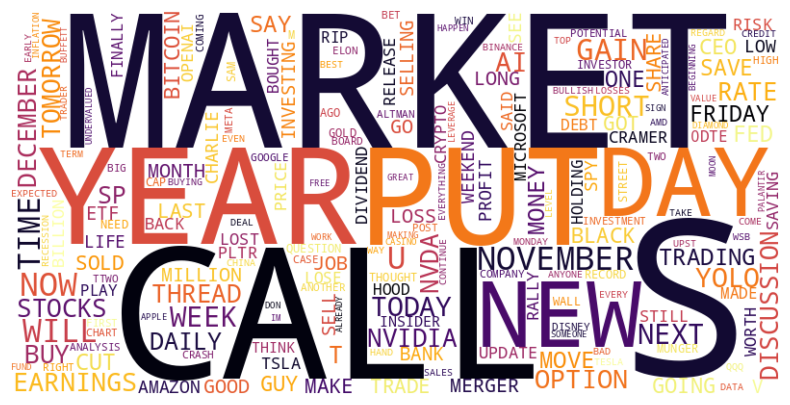

In [235]:
import string

pattern = f"[{re.escape(string.punctuation)}]"

# Replace punctuation with a space, convert to uppercase, and strip spaces
text = " ".join(re.sub(pattern, ' ', title).upper().strip() for title in df['title'])


# text = " ".join(title.upper().strip() for title in df['title'])# Create a WordCloud object
# List of words to remove
words_to_remove = ["****","STOCK", "removed", "stock", "market", "will", 'call', 'put','year' , 'calls']  

# Remove unwanted words
filtered_text = ' '.join(word for word in text.split() if word not in words_to_remove)

wordcloud = WordCloud(background_color="white", width=800, height=400, collocations=False, random_state=42,colormap=cm.inferno).generate(filtered_text)
# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

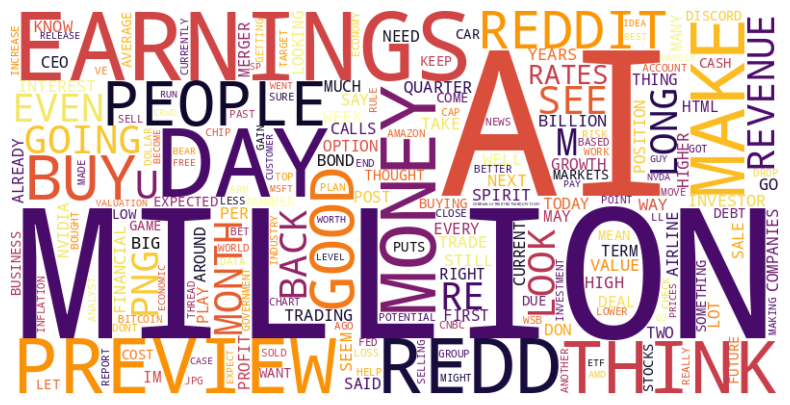

AI: 1.0
MILLION: 0.9568965517241379
EARNINGS: 0.9482758620689655
DAY: 0.9396551724137931
PREVIEW: 0.9396551724137931
MONEY: 0.9310344827586207
REDD: 0.9224137931034483
MAKE: 0.8879310344827587
THINK: 0.8879310344827587
PEOPLE: 0.8879310344827587
BUY: 0.8620689655172413
GOOD: 0.8362068965517241
REDDIT: 0.8275862068965517
GOING: 0.8189655172413793
SEE: 0.8103448275862069
U: 0.7931034482758621
EVEN: 0.7586206896551724
MONTH: 0.7586206896551724
M: 0.7241379310344828
RE: 0.7155172413793104
REVENUE: 0.7155172413793104
BACK: 0.7068965517241379
PNG: 0.7068965517241379
LOOK: 0.6982758620689655
LONG: 0.6896551724137931
RATES: 0.6896551724137931
INVESTOR: 0.6724137931034483
WEEK: 0.6724137931034483
TRADING: 0.6637931034482759
QUARTER: 0.6637931034482759
HIGH: 0.6551724137931034
WAY: 0.646551724137931
WELL: 0.646551724137931
YEARS: 0.6379310344827587
VALUE: 0.6293103448275862
GO: 0.6293103448275862
BIG: 0.6293103448275862
INTEREST: 0.6120689655172413
FINANCIAL: 0.6120689655172413
NEXT: 0.603448275

In [237]:
import string

# Apply the translation table to each title, convert to uppercase, and strip spaces
text = " ".join(re.sub(pattern, ' ', title).upper().strip() for title in df['selftext'])

# Convert the list of words to remove to uppercase
words_to_remove = ["LAST","EARNING","ONE","RATE","NOW","PUT","CALL","****","DELETED", "REMOVED", "EDIT", "WILL", "STOCK", "SHARE", "HTTPS", "X200B", "COMPANY", "SHARES", "MARKET", "SHORT", "S","T", "PRICE", "NEW", "YEAR", "TIME"]

# Remove unwanted words
filtered_text = ' '.join([word.strip().upper() for word in text.split() if word.strip().upper() not in words_to_remove])

wordcloud = WordCloud(background_color="white", width=800, height=400, collocations=False, random_state=42,colormap=cm.inferno).generate(filtered_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Print word frequencies
word_frequencies = wordcloud.words_
for word, freq in word_frequencies.items():
    print(f"{word}: {freq}")

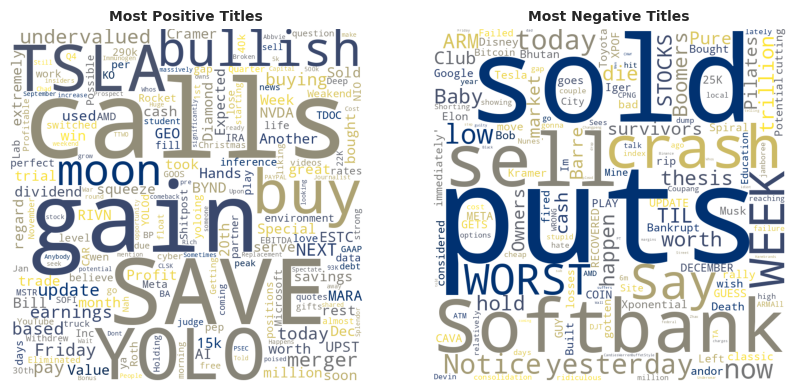

In [238]:
from matplotlib import cm
Most_Positive = df_with_ngrams[df_with_ngrams['title_sentiment'].between(0.5,1)]['title']
Most_Negative = df_with_ngrams[df_with_ngrams['title_sentiment'].between(-1,-.5)]['title']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)
################################
# Tokenize the texts into words
positive_words = Most_Positive_text.split()
negative_words = Most_Negative_text.split()

# Find common words
common_words = set(positive_words) & set(negative_words)

# Filter out common words
filtered_positive_words = [word for word in positive_words if word.upper() not in common_words]
filtered_positive_words = [word for word in filtered_positive_words if word.upper() not in words_to_remove]
filtered_negative_words = [word for word in negative_words if word.upper() not in common_words]
filtered_negative_words = [word for word in filtered_negative_words if word.upper() not in words_to_remove]

# Rejoin the words into strings
filtered_positive_text = ' '.join(filtered_positive_words)
filtered_negative_text = ' '.join(filtered_negative_words)

# Generate word clouds
pwc = WordCloud(width=800, height=800, collocations=False, background_color='white', random_state=42,colormap=cm.cividis).generate(filtered_positive_text)
nwc = WordCloud(width=800, height=800, collocations=False, background_color='white', random_state=42,colormap=cm.cividis).generate(filtered_negative_text)


##################################################

plt.figure(figsize=(10, 6)) 
plt.subplot(1,2,1)
plt.title('Most Positive Titles',fontsize=10,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Most Negative Titles',fontsize=10,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

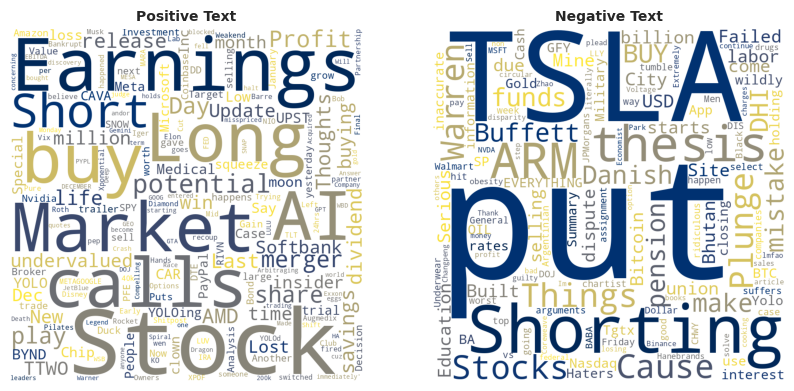

In [239]:

Most_Positive = df_with_ngrams[df_with_ngrams['selftext_sentiment'].between(0.5,1)]['title']
Most_Negative = df_with_ngrams[df_with_ngrams['selftext_sentiment'].between(-1,-.5)]['title']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)
################################
# Tokenize the texts into words
positive_words = Most_Positive_text.split()
negative_words = Most_Negative_text.split()

# Find common words
common_words = set(positive_words) & set(negative_words)

# Filter out common words
filtered_positive_words = [word for word in positive_words if word not in common_words]
filtered_negative_words = [word for word in negative_words if word not in common_words]

# Rejoin the words into strings
filtered_positive_text = ' '.join(filtered_positive_words)
filtered_negative_text = ' '.join(filtered_negative_words)

# Generate word clouds
pwc = WordCloud(width=800, height=800, collocations=False, background_color='white', random_state=42,colormap=cm.cividis).generate(filtered_positive_text)
nwc = WordCloud(width=800, height=800, collocations=False, background_color='white', random_state=42,colormap=cm.cividis).generate(filtered_negative_text)


##################################################


plt.figure(figsize=(10, 6)) 
plt.subplot(1,2,1)
plt.title('Positive Text',fontsize=10,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Negative Text',fontsize=10,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

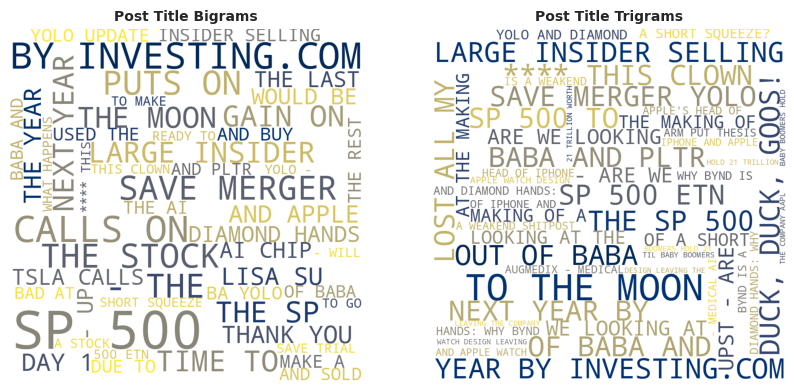

In [240]:
# Generate a word cloud
bi =  WordCloud(width=800, height=800, collocations=False, background_color='white', random_state=42,colormap=cm.cividis).generate_from_frequencies(bigram_counts)
tri = WordCloud(width=800, height=800, collocations=False, background_color='white', random_state=42,colormap=cm.cividis).generate_from_frequencies(trigram_counts)

plt.figure(figsize=(10, 6)) 
plt.subplot(1,2,1)
plt.title('Post Title Bigrams',fontsize=10,fontweight='bold')
plt.imshow(bi)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Post Title Trigrams',fontsize=10,fontweight='bold')
plt.imshow(tri)
plt.axis('off')

plt.show()

# Named Entity Recognition

In [64]:
import spacy
from spacy import displacy

import en_core_web_lg
nlp = en_core_web_lg.load()

In [49]:
def extract_entities(text):
    doc = nlp(text)
    return [(X.text, X.label_) for X in doc.ents]

In [50]:
df_tickers_exist

,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,...,created_EST_date,title_tickers,selftext_tickers,tickers,title_sentiment,selftext_sentiment,overall_sentiment,score_weighted_sentiment,bigrams,trigrams
0,18d1ifi,t5_2th52,wallstreetbets,Slut_Spoiler,1.701972e+09,/r/wallstreetbets/comments/18d1ifi/elon_musk_g...,"Elon Musk goes off on Disney CEO Bob Iger, say...",https:www.businessinsider.comelon-musk-disney-...,4,0,...,2023-12-07,[],[AG],[AG],-0.5574,0.9563,0.19945,0.00000,"[ELON MUSK, MUSK GOES, GOES OFF, OFF ON, ON DI...","[ELON MUSK GOES, MUSK GOES OFF, GOES OFF ON, O..."
1,18d1eua,t5_2th52,wallstreetbets,Routine-Ad-5424,1.701972e+09,/r/wallstreetbets/comments/18d1eua/gdhg_time_t...,GDHG TIME TO BOTTOM HUNTING,1st Prediction: \nI just predicted that the ...,3,1,...,2023-12-07,[GDHG],[GDHG],[GDHG],0.0000,-0.4003,-0.40030,-0.40030,"[GDHG TIME, TIME TO, TO BOTTOM, BOTTOM HUNTING]","[GDHG TIME TO, TIME TO BOTTOM, TO BOTTOM HUNTING]"
5,18d0h3f,t5_2th52,wallstreetbets,Dragonian36,1.701970e+09,/r/wallstreetbets/comments/18d0h3f/is_cava_dum...,Is CAVA dumping this month?!?,,4,3,...,2023-12-07,[CAVA],[],[CAVA],-0.4501,0.0000,-0.45010,-1.35030,"[IS CAVA, CAVA DUMPING, DUMPING THIS, THIS MON...","[IS CAVA DUMPING, CAVA DUMPING THIS, DUMPING T..."
6,18d0g1y,t5_2th52,wallstreetbets,Veritatis-Cupitor,1.701969e+09,/r/wallstreetbets/comments/18d0g1y/cava_decemb...,CAVA DECEMBER SHORT PLAY (Potential Crash and...,Below is my personal thesis based on my own re...,3,3,...,2023-12-07,"[CAVA, PLAY]","[CAVA, SG]","[CAVA, SG, PLAY]",-0.8020,0.9884,0.09320,0.27960,"[CAVA DECEMBER, DECEMBER SHORT, SHORT PLAY, PL...","[CAVA DECEMBER SHORT, DECEMBER SHORT PLAY, SHO..."
11,18czn4s,t5_2th52,wallstreetbets,stockocean,1.701967e+09,/r/wallstreetbets/comments/18czn4s/palantir_pl...,Palantir (PLTR) down nearly 20 since large ins...,Posted about PLTR large insider selling two we...,9,18,...,2023-12-07,[PLTR],[PLTR],[PLTR],0.0000,0.4574,0.45740,8.23320,"[PALANTIR (PLTR), (PLTR) DOWN, DOWN NEARLY, NE...","[PALANTIR (PLTR) DOWN, (PLTR) DOWN NEARLY, DOW..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,17ztdhb,t5_2th52,wallstreetbets,ih8myylife,1.700500e+09,/r/wallstreetbets/comments/17ztdhb/nvda_earnings/,NVDA earnings,so you wanna short or long nvda into ER but ur...,64,16,...,2023-11-20,[NVDA],[NVDA],[NVDA],0.0000,-0.8953,-0.89530,-14.32480,[NVDA EARNINGS],[]
859,17zsozj,t5_2th52,wallstreetbets,DutchKevv,1.700498e+09,/r/wallstreetbets/comments/17zsozj/its_not_a_j...,It's not a joke. OpenAI destroyed itself in a ...,I'm just baffled how nobody in upper managemen...,1913,14323,...,2023-11-20,[],[MSFT],[MSFT],-0.6234,0.9017,0.13915,1993.04545,"[IT'S NOT, NOT A, A JOKE., JOKE. OPENAI, OPENA...","[IT'S NOT A, NOT A JOKE., A JOKE. OPENAI, JOKE..."
861,17zsj3x,t5_2th52,wallstreetbets,luzzi5luvmywatches,1.700498e+09,/r/wallstreetbets/comments/17zsj3x/nvda_option...,NVDA options Calls so expensive.,Someone's holding huge bags!!!!!\n\nI know eve...,38,17,...,2023-11-20,[NVDA],[],[NVDA],0.7184,0.9518,0.83510,14.19670,"[NVDA OPTIONS, OPTIONS CALLS, CALLS SO, SO EXP...","[NVDA OPTIONS CALLS, OPTIONS CALLS SO, CALLS S..."
862,17zsevz,t5_2th52,wallstreetbets,BagelsRTheHoleTruth,1.700498e+09,/r/wallstreetbets/comments/17zsevz/robinhood_t...,"Robinhood to launch subscription service, comp...","Robinhood Markets Inc. (HOOD), the popular onl...",16,16,...,2023-11-20,[],[HOOD],[HOOD],0.0000,0.9823,0.98230,15.71680,"[ROBINHOOD TO, TO LAUNCH, LAUNCH SUBSCRIPTION,...","[ROBINHOOD TO LAUNCH, TO LAUNCH SUBSCRIPTION, ..."


In [51]:
df_tickers_exist.loc[:,'title_entities'] = df_tickers_exist['title'].apply(extract_entities)
df_tickers_exist.loc[:,'selftext_entities'] = df_tickers_exist['selftext'].apply(extract_entities)
df_tickers_exist.head()

/tmp/ipykernel_7951/4160087578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tickers_exist.loc[:,'title_entities'] = df_tickers_exist['title'].apply(extract_entities)
/tmp/ipykernel_7951/4160087578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tickers_exist.loc[:,'selftext_entities'] = df_tickers_exist['selftext'].apply(extract_entities)


,id,subreddit_id,subreddit,author,created_utc,permalink,title,selftext,num_comments,score,...,selftext_tickers,tickers,title_sentiment,selftext_sentiment,overall_sentiment,score_weighted_sentiment,bigrams,trigrams,title_entities,selftext_entities
0,18d1ifi,t5_2th52,wallstreetbets,Slut_Spoiler,1.701972e+09,/r/wallstreetbets/comments/18d1ifi/elon_musk_g...,"Elon Musk goes off on Disney CEO Bob Iger, say...",https:www.businessinsider.comelon-musk-disney-...,4,0,...,[AG],[AG],-0.5574,0.9563,0.19945,0.0000,"[ELON MUSK, MUSK GOES, GOES OFF, OFF ON, ON DI...","[ELON MUSK GOES, MUSK GOES OFF, GOES OFF ON, O...","[(Elon Musk, PERSON), (Disney, ORG), (Bob Iger...","[(bob-iger, PERSON), (bob-iger, PERSON), (Elon..."
1,18d1eua,t5_2th52,wallstreetbets,Routine-Ad-5424,1.701972e+09,/r/wallstreetbets/comments/18d1eua/gdhg_time_t...,GDHG TIME TO BOTTOM HUNTING,1st Prediction: \nI just predicted that the ...,3,1,...,[GDHG],[GDHG],0.0000,-0.4003,-0.40030,-0.4003,"[GDHG TIME, TIME TO, TO BOTTOM, BOTTOM HUNTING]","[GDHG TIME TO, TIME TO BOTTOM, TO BOTTOM HUNTING]","[(GDHG TIME TO BOTTOM HUNTING, ORG)]","[(1st, ORDINAL), (the first half-hour, DATE), ..."
5,18d0h3f,t5_2th52,wallstreetbets,Dragonian36,1.701970e+09,/r/wallstreetbets/comments/18d0h3f/is_cava_dum...,Is CAVA dumping this month?!?,,4,3,...,[],[CAVA],-0.4501,0.0000,-0.45010,-1.3503,"[IS CAVA, CAVA DUMPING, DUMPING THIS, THIS MON...","[IS CAVA DUMPING, CAVA DUMPING THIS, DUMPING T...","[(this month, DATE)]",[]
6,18d0g1y,t5_2th52,wallstreetbets,Veritatis-Cupitor,1.701969e+09,/r/wallstreetbets/comments/18d0g1y/cava_decemb...,CAVA DECEMBER SHORT PLAY (Potential Crash and...,Below is my personal thesis based on my own re...,3,3,...,"[CAVA, SG]","[CAVA, SG, PLAY]",-0.8020,0.9884,0.09320,0.2796,"[CAVA DECEMBER, DECEMBER SHORT, SHORT PLAY, PL...","[CAVA DECEMBER SHORT, DECEMBER SHORT PLAY, SHO...","[(CAVA, ORG), (DECEMBER, DATE)]","[(1, CARDINAL), (CATALYST, ORG), (CAVA Group, ..."
11,18czn4s,t5_2th52,wallstreetbets,stockocean,1.701967e+09,/r/wallstreetbets/comments/18czn4s/palantir_pl...,Palantir (PLTR) down nearly 20 since large ins...,Posted about PLTR large insider selling two we...,9,18,...,[PLTR],[PLTR],0.0000,0.4574,0.45740,8.2332,"[PALANTIR (PLTR), (PLTR) DOWN, DOWN NEARLY, NE...","[PALANTIR (PLTR) DOWN, (PLTR) DOWN NEARLY, DOW...","[(Palantir, ORG), (PLTR, ORG), (nearly 20, CAR...","[(PLTR, ORG), (two weeks ago, DATE), (November..."


# Text summarizing

### Bert

In [33]:

# !pip install torch
# !pip install bert-extractive-summarizer
# import torch
# from summarizer import Summarizer
# model = Summarizer()
# df_tickers_exist['bert_summary'] = model(df_tickers_exist['title'], min_length=60)
# df_tickers_exist

### Transformers

In [34]:
# !pip install transformers

In [35]:
# from transformers import pipeline

# summarizer = pipeline("summarization")
# df_tickers_exist['transformers_title_summary'] = summarizer(df_tickers_exist['title'],  max_length=130, min_length=30, do_sample=False)[0]

In [36]:
# df_tickers_exist